Prep for function that calculates mean distance to polygon edge for all infinite points inside, using sampling.

TODO:
* Uniform grids (triangles, hex, or square) instead of random sampling

In [316]:
import libpysal
import geopandas as gpd
import numpy as np
import libpysal
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
import shapely
import pandas as pd
from libpysal.cg import KDTree
from libpysal.weights import KNN
import esda
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
# import scipy as sp
from scipy import stats as sps
import pointpats as pp
from shapely.geometry import Polygon, Point, MultiPoint
import leafmap

In [231]:
## I/O

lakes_gdf = gpd.read_file('/mnt/g/Ch4/misc/WBD_sample.shp').to_crs("ESRI:102001")

In [232]:
## View
m = leafmap.Map(google_map='SATELLITE')
m.add_gdf(lakes_gdf, fill_colors=['red'])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [275]:
## loop
for i, feature in enumerate(lakes_gdf.loc[0:3, 'geometry']): # 0:4
    rand_pts = pp.random.poisson(feature, size=1000)
    # rand_pts = pp.random.cluster_poisson(feature, size=100, n_seeds=40) # intensity=None, cluster_radius=None
    rand_pts_geom = [Point(pt) for pt in rand_pts]
    # random_pts_gdf = gpd.GeoDataFrame(geometry = [Point(pt) for pt in random_pts], crs=lakes_gdf.crs)
    rand_pts_gs = gpd.GeoSeries([Point(pt) for pt in rand_pts], crs=lakes_gdf.crs)
    lakes_gdf.loc[i, 'mean_dist2shore'] = rand_pts_gs.distance(feature.boundary).mean()
    # rand_pts_dist = gpd.

# pp.random.poisson(shp.loc[0, 'geometry'], size=30)
# shp.loc[0, 'geometry']

lakes_gdf.head()

,OBJECTID,ID,GRIDCODE,Area,SI,Shape_Leng,Shape_Area,PA,PA_Circle,Perimeter,river,on_glacier,geometry,mean_dist2shore
0,318312.0,883539.0,1.0,0.035178,1.115111,0.008823,4.540358e-06,21.076057,18.900415,0.741407,None,None,"POLYGON ((606034.179 1256955.080, 606029.835 1...",31.691027
1,318452.0,884210.0,1.0,0.002896,1.281111,0.003251,3.736590e-07,84.396667,65.877731,0.244376,None,None,"POLYGON ((609803.427 1256749.361, 609712.381 1...",7.241139
2,318470.0,884329.0,1.0,0.019256,2.054513,0.012196,2.484794e-06,52.485142,25.546265,1.010628,None,None,"POLYGON ((610127.148 1256791.776, 610141.427 1...",11.072489
3,318699.0,885767.0,1.0,2.879962,2.544130,0.186279,3.716075e-04,5.314359,2.088871,15.305153,None,None,"POLYGON ((607603.646 1255653.473, 607617.933 1...",117.524756


<AxesSubplot:>

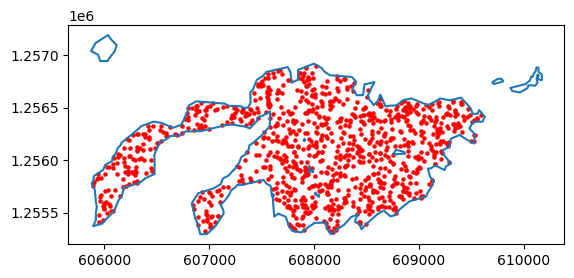

In [274]:
## Alt plot
%matplotlib inline
fig, ax = plt.subplots()
lakes_gdf.boundary.plot(ax=ax)
rand_pts_gs.plot(c='red', ax=ax, markersize=5)

In [235]:
pts_gdf = gpd.GeoDataFrame(geometry = [Point(pt) for pt in rand_pts], crs=lakes_gdf.crs)
m.add_gdf(lakes_gdf)
m.add_gdf(pts_gdf)
m

Map(center=[51.085834663838725, -87.27683764763927], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [237]:
feature.boundary.distance(rand_pts_geom[20]) #, align=False)
# help(feature.distance)
# gpd.GeoSeries.distance
# lakes_gdf.loc[0:1, 'geometry'].boundary.distance(rand_pts_gs[1:5], align=False)
type(lakes_gdf.loc[0:1, 'geometry'])
type(lakes_gdf.loc[1, 'geometry'])
type(lakes_gdf.iloc[1, :])
type(lakes_gdf.iloc[0:1, :])
# lakes_gdf.loc[1, 'geometry']
rand_pts_gs.distance(feature.boundary) # <<<< THIS IS IT!
rand_pts_gs.distance(feature.boundary).mean()

134.22572681821518

## Run on real data!

Variables:
```
Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'Reference', 'Site Name', 'Location', 'latitude', 'longitude',
       'Study Year', 'area (ha)', 'ch4 (umol/', 'co2 (umol/', 'temp (C)',
       'temp (esti', 'atm. co2', 'atm. ch4', 'mean_bound', 'geometry'],
      dtype='object')'
      ```

In [312]:
## Function
def calcMeanBoundDist(gdf):
    '''Calculate the mean distance to polygon boundary for an arbitrary number of random points inside.'''
    for i, feature in tqdm(enumerate(gdf.loc[:, 'geometry'])): # 0:4
        rand_pts = pp.random.poisson(feature, size=1000)
        rand_pts_gs = gpd.GeoSeries([Point(pt) for pt in rand_pts], crs=gdf.crs)
        gdf.loc[i, 'mean_bound_dist'] = rand_pts_gs.distance(feature.boundary).mean()
    return gdf

In [313]:
## I/O
# pth = '/mnt/g/Ch4/misc/HL_w_HR16.shp'
pth = '/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/out/HL_Sweden.shp'
pth_out = pth.replace('.shp','_md.shp')
# proj = '+proj=laea +lon_0=-13 +lat_0=18.5 +datum=WGS84 +units=m +no_defs' # from https://projectionwizard.org/#
proj = '+proj=tcea +lon_0=13.7109375 +datum=WGS84 +units=m +no_defs' # for Sweden

In [317]:
## Load
lakes_gdf = gpd.read_file(pth).to_crs(proj) # TODO: which projection for global equal area

## Compute
lakes_gdf_out = calcMeanBoundDist(lakes_gdf)

## Write out
lakes_gdf_out.to_file(pth_out)

127it [01:14,  2.03it/s]

In [295]:
## Plotting params
sns.set_theme('notebook')
sns.set_style('ticks')


Text(0.5, 1.0, 'Area vs mean distance to shoreline')

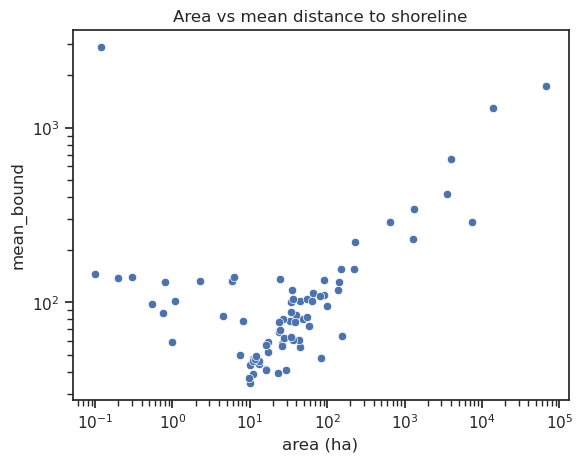

In [309]:
## View and plot relationship to area
sns.scatterplot(lakes_gdf, x='area (ha)', y = 'mean_bound')
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Area vs mean distance to shoreline')

Text(0.5, 1.0, 'Mean distance to shoreline vs ch4')

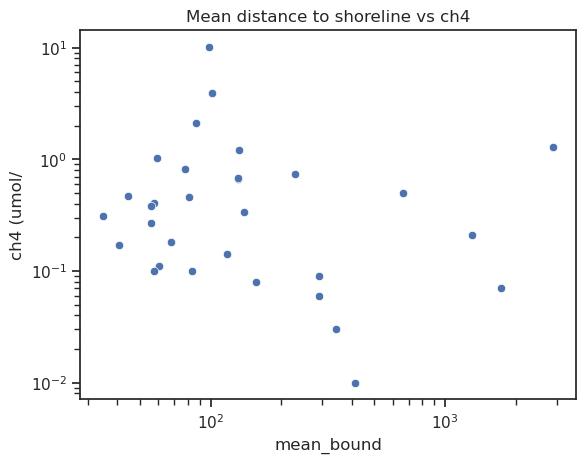

In [310]:
## View and plot relationship to ch4
sns.scatterplot(lakes_gdf, x='mean_bound', y = 'ch4 (umol/')
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Mean distance to shoreline vs ch4')

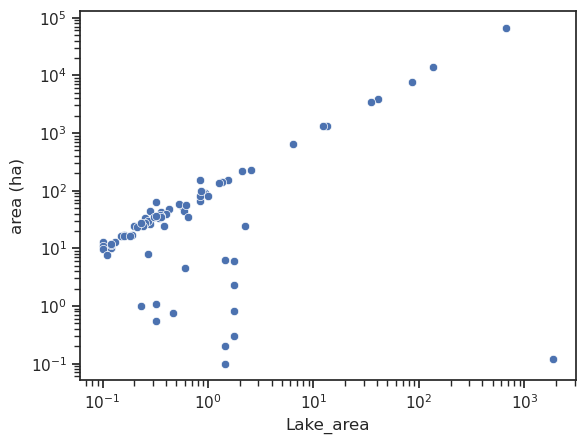

In [305]:
## View and plot areas from different ds
sns.scatterplot(lakes_gdf, x='Lake_area', y = 'area (ha)')
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Hydrolakes vs HR16 areas')

Text(0.5, 1.0, 'Hydrolakes vs map projection area')

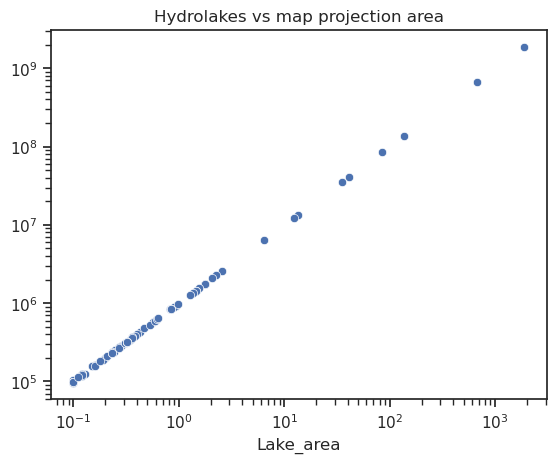

In [307]:
## View and plot areas from different ds
sns.scatterplot(lakes_gdf, x='Lake_area', y = lakes_gdf.area)
# plt.scatter(lakes_gdf['area (ha)'], lakes_gdf['mean_bound'])
plt.xscale('log')
plt.yscale('log')
plt.title('Hydrolakes vs map projection area')

## Testing examples

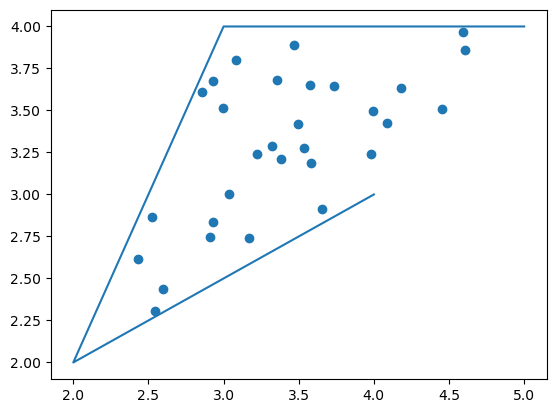

In [67]:
## Pointpats random points generation
## https://stackoverflow.com/questions/56393503/how-can-i-generate-random-coordinates-inside-a-polygon

 
# Coordinates of polygon edges
coords = [[5,4],[3,4], [2,2],[4,3]]
point1 = Point([3,3])
point2 = Point([0,4])
pgon = Polygon(coords)

# Generates 5 points inside polygon
random_pts = pp.random.poisson(pgon, size=30)

## View
coords_np = np.array(coords)
plt.plot(coords_np[:,0], coords_np[:,1])
plt.scatter(random_pts[:,0], random_pts[:,1])

In [68]:
## Calc distance from point to poly
from libpysal.cg import get_polygon_point_dist
get_polygon_point_dist(pgon, point1)

AttributeError: 'Polygon' object has no attribute 'bounding_box'

In [117]:
dir(pointpats)

['HexagonM',
 'PointPattern',
 'PointProcess',
 'PoissonClusterPointProcess',
 'PoissonPointProcess',
 'QStatistic',
 'RectangleM',
 'SpaceTimeEvents',
 'Window',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_circle',
 '_deprecated_distance_statistics',
 'as_window',
 'centrography',
 'distance_statistics',
 'dtot',
 'ellipse',
 'euclidean_median',
 'f',
 'f_test',
 'g',
 'g_test',
 'geometry',
 'hull',
 'j',
 'j_test',
 'jacquez',
 'k',
 'k_test',
 'knox',
 'l',
 'l_test',
 'manhattan_median',
 'mantel',
 'mbr',
 'mean_center',
 'minimum_bounding_rectangle',
 'minimum_rotated_rectangle',
 'modified_knox',
 'pointpattern',
 'poly_from_bbox',
 'process',
 'quadrat_statistics',
 'random',
 'skyum',
 'spacetime',
 'std_distance',
 'to_ccf',
 'util',
 'weighted_mean_center',
 'window']